# Quantitative Trading
The code takes a bit less than 10min to run in total


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the sheets using pd.read_excel
returns = pd.read_excel('Book1.xlsx', sheet_name='Returns', index_col=0)
live = pd.read_excel('Book1.xlsx', sheet_name='Live', index_col=0)
fama_french = pd.read_excel('Book1.xlsx', sheet_name='Fama_French', index_col=0)


In [2]:
# Compute momentum using a cumulative product over the window
momentum = pd.DataFrame(index=returns.index, columns=returns.columns, dtype=float)

for t in range(52, len(returns)):
    # Define the window: from t-52 (inclusive) to t-4 (exclusive)
    window_returns = returns.iloc[t-52:t-4]
    window_live = live.iloc[t-52:t-4]
    
    # Compute cumulative return as the product of (1 + returns) minus 1
    cum_return = (window_returns + 1).prod() - 1
    
    momentum.iloc[t] = cum_return

# remove initial rows where momentum is not computed.
momentum = momentum.iloc[52:]

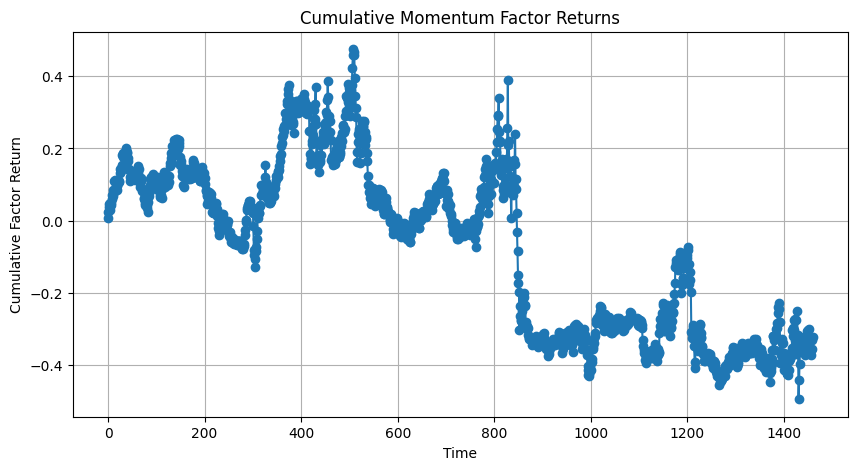

In [3]:
# Convert momentum to a NumPy array
momentum = momentum.values


def famaMacBethOneFactor(returns, momentum, live):
    T, N = returns.shape
    gamma = np.full((T,), np.nan)    
    resid = np.full((T, N), np.nan)    

    # Loop over weeks starting from 1 because we use t-1 for momentum
    for t in range(1, T):
        # the y variable is one-week ahead returns at time t for all stocks
        Y = returns[t, :]
        # the x variable is momentum from the previous week (t-1) for all stocks
        X = momentum[t-1, :]
        # only consider stocks that are live in week t
        live_ind = live[t, :]

        # bolean variable valid if stock is live and has non-missing Y and X
        valid = (live_ind == 1) & (~np.isnan(Y)) & (~np.isnan(X))
        
        # If too few stocks remain, skip this week
        if np.sum(valid) < 2:
            continue

        # Extract valid observations
        Y_valid = Y[valid]
        # Build design matrix with an intercept and the momentum factor
        X_valid = np.column_stack((np.ones(np.sum(valid)), X[valid]))

        # Solve the OLS regression Y_valid = intercept + slope * X_valid
        coefs, _, _, _ = np.linalg.lstsq(X_valid, Y_valid, rcond=None)
        
        # store factor returns
        gamma[t] = coefs[1]
        
        # Compute residuals and store residuals
        pred = X_valid.dot(coefs)
        resid[t, valid] = Y_valid - pred

    return gamma, resid


# Convert returns and live DataFrames to NumPy arrays
returns = returns.values
live = live.values   

# Trim the first 53 rows if needed (matching your earlier adjustment)
returns = returns[52:, :]   
live = live[52:, :]  # live indicator (1 = live, 0 = dead)


# we run the reg
gamma, residuals = famaMacBethOneFactor(returns, momentum, live)

# plot factor returns
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(gamma[1:]), marker='o')
plt.title("Cumulative Momentum Factor Returns")
plt.xlabel("Time")
plt.ylabel("Cumulative Factor Return")
plt.grid(True)
plt.show()



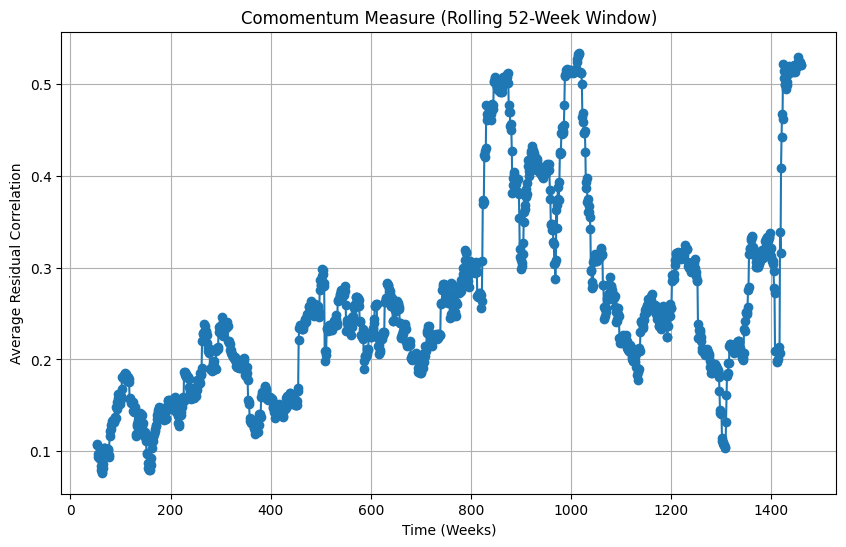

In [4]:
def compute_comomentum(returns, ff, live, window=52):

    T, N = returns.shape
    comom = np.full((T,), np.nan)
    
    for t in range(window, T):
        # Define the rolling window indices [t-window, t)
        ret_window = returns[t-window:t, :]   
        ff_window = ff[t-window:t, :]           
        live_window = live[t-window:t, :]       
        
        # Identify stocks that are live for the entire window
        live_mask = (live_window == 1).all(axis=0)
        residuals_list = []
        
        # Run regression for each qualifying stock
        for i in range(N):
            if not live_mask[i]:
                continue
            y = ret_window[:, i]
            X = np.hstack((np.ones((window, 1)), ff_window))
            if np.isnan(y).any() or np.isnan(X).any():
                continue
            coefs, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
            resid_i = y - X.dot(coefs)
            residuals_list.append(resid_i)
        
        # Compute average pairwise correlation if at least 2 stocks qualify
        if len(residuals_list) < 2:
            continue
        
        resid_matrix = np.column_stack(residuals_list)
        corr_matrix = np.corrcoef(resid_matrix, rowvar=False)
        # Get the off-diagonal elements: use the upper triangle indices (excluding diagonal)
        triu_idx = np.triu_indices_from(corr_matrix, k=1)
        avg_corr = np.nanmean(corr_matrix[triu_idx])
        comom[t] = avg_corr
        
    return comom


returns_np = returns 
live_np = live       
ff_np = fama_french.values   

# Now compute the comomentum measure
comomentum = compute_comomentum(returns_np, ff_np, live_np, window=52)


# Plot the computed comomentum measure
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(comomentum, marker='o')
plt.title("Comomentum Measure (Rolling 52-Week Window)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Average Residual Correlation")
plt.grid(True)
plt.show()


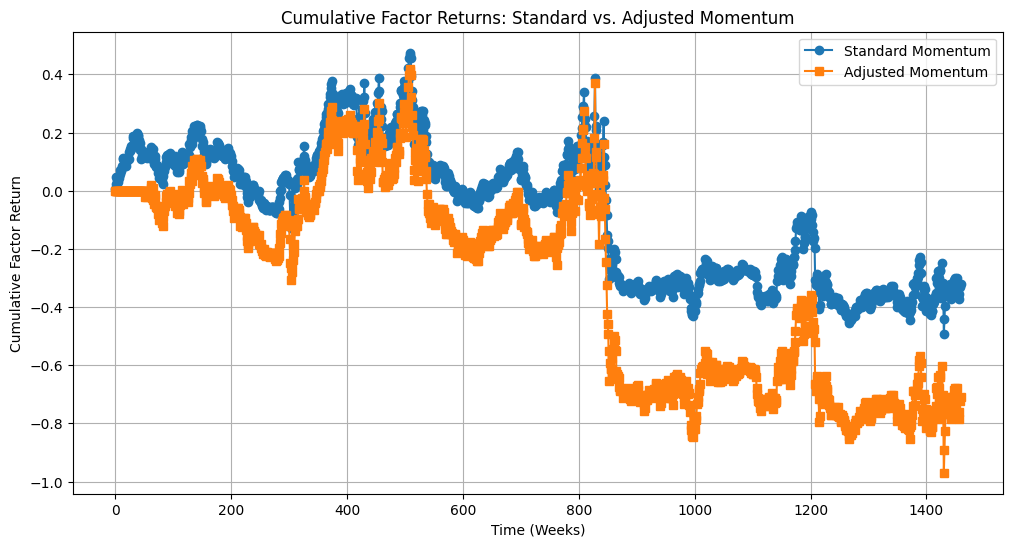

Standard Momentum Factor Returns:
Annualised Mean: -0.0114, Annualised Std: 0.1636

Adjusted Momentum Factor Returns:
Annualised Mean: -0.0262, Annualised Std: 0.2186

Sharpe Ratios:
Standard Momentum: -0.0700
Adjusted Momentum: -0.1199


In [5]:
# First, compute adjusted momentum exposures.
# We define the adjustment weight for each week t as: weight[t] = 1 / (1 + comomentum[t])
# Then for each week, for each stock, adjusted_momentum[t, :] = momentum[t, :] * weight[t]
# We must ensure alignment meaning that comomentum is defined for weeks t where momentum is defined.


T, N = momentum.shape
adjusted_momentum = np.full_like(momentum, np.nan)

for t in range(T):
    # Check if comomentum[t] is a valid number
    if np.isnan(comomentum[t]):
        continue
    weight = 1 / (1 + comomentum[t])
    # Adjust the momentum exposures at week t by this weight
    adjusted_momentum[t, :] = momentum[t, :] * weight

# Now re-run the Fama–MacBeth regressions using both standard momentum and adjusted momentum
gamma_standard, resid_standard = famaMacBethOneFactor(returns, momentum, live)
gamma_adjusted, resid_adjusted = famaMacBethOneFactor(returns, adjusted_momentum, live)


plt.figure(figsize=(12,6))

cum_gamma_std = np.nancumsum(gamma_standard[1:])
cum_gamma_adj = np.nancumsum(gamma_adjusted[1:])

plt.plot(cum_gamma_std, label='Standard Momentum', marker='o')
plt.plot(cum_gamma_adj, label='Adjusted Momentum', marker='s')
plt.title("Cumulative Factor Returns: Standard vs. Adjusted Momentum")
plt.xlabel("Time (Weeks)")
plt.ylabel("Cumulative Factor Return")
plt.legend()
plt.grid(True)
plt.show()

# Compute descriptive statistics for both factor return series.

std_gamma = gamma_standard[~np.isnan(gamma_standard)]
adj_gamma = gamma_adjusted[~np.isnan(gamma_adjusted)]

annualised_mean_std = np.mean(std_gamma) * 52
annualised_std_std = np.std(std_gamma) * np.sqrt(52)

annualised_mean_adj = np.mean(adj_gamma) * 52
annualised_std_adj = np.std(adj_gamma) * np.sqrt(52)

sharpe_std = annualised_mean_std / annualised_std_std
sharpe_adj = annualised_mean_adj / annualised_std_adj

print("Standard Momentum Factor Returns:")
print(f"Annualised Mean: {annualised_mean_std:.4f}, Annualised Std: {annualised_std_std:.4f}")

print("\nAdjusted Momentum Factor Returns:")
print(f"Annualised Mean: {annualised_mean_adj:.4f}, Annualised Std: {annualised_std_adj:.4f}")

print("\nSharpe Ratios:")
print(f"Standard Momentum: {sharpe_std:.4f}")
print(f"Adjusted Momentum: {sharpe_adj:.4f}")


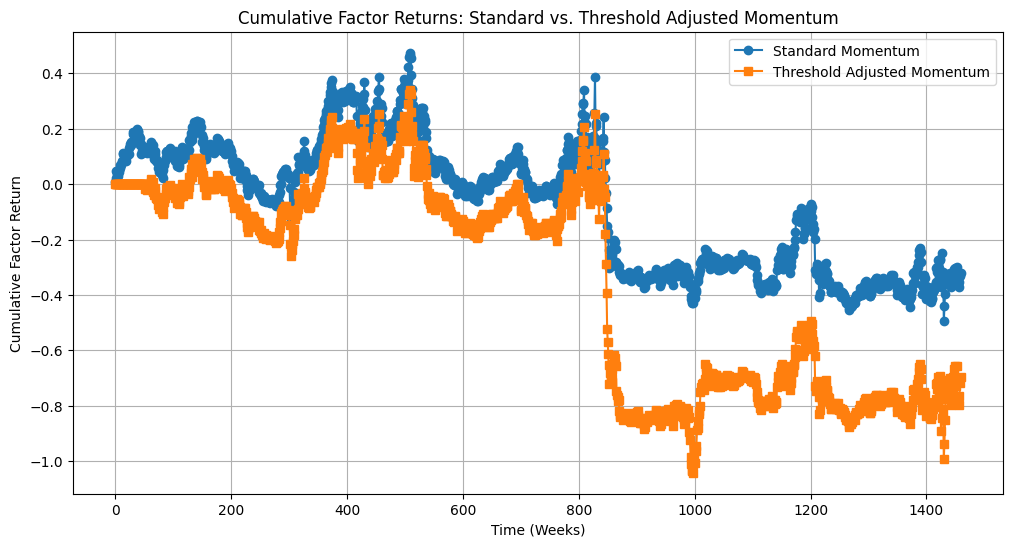

Standard Momentum Factor Returns:
Annualised Mean: -0.0114, Annualised Std: 0.1636

Threshold Adjusted Momentum Factor Returns:
Annualised Mean: -0.0258, Annualised Std: 0.1822

Sharpe Ratios:
Standard Momentum: -0.0700
Threshold Adjusted Momentum: -0.1415


In [6]:
# Define a threshold for comomentum (adjust as needed based on your data)
threshold = 0.5 

# Initialize the adjusted momentum array using threshold-based rule
# Here, if comomentum[t] exceeds the threshold, we reduce exposure 
T, N = momentum.shape
threshold_adjusted_momentum = np.full_like(momentum, np.nan)

for t in range(T):
    if np.isnan(comomentum[t]):
        # If comomentum is missing, leave adjusted momentum as NaN
        continue
    # Define weight: if comomentum > threshold, reduce exposure  else full exposure
    if comomentum[t] > threshold:
        weight = 0.5  # exposure reduced
    else:
        weight = 1.0  # full exposure
    threshold_adjusted_momentum[t, :] = momentum[t, :] * weight

# Now re-run the Fama–MacBeth regressions using both standard momentum and adjusted momentum
gamma_standard, resid_standard = famaMacBethOneFactor(returns, momentum, live)
gamma_threshold, resid_threshold = famaMacBethOneFactor(returns, threshold_adjusted_momentum, live)

# now we plot
cum_gamma_std = np.nancumsum(gamma_standard[1:])
cum_gamma_thresh = np.nancumsum(gamma_threshold[1:])

plt.figure(figsize=(12,6))
plt.plot(cum_gamma_std, label='Standard Momentum', marker='o')
plt.plot(cum_gamma_thresh, label='Threshold Adjusted Momentum', marker='s')
plt.title("Cumulative Factor Returns: Standard vs. Threshold Adjusted Momentum")
plt.xlabel("Time (Weeks)")
plt.ylabel("Cumulative Factor Return")
plt.legend()
plt.grid(True)
plt.show()

# Compute descriptive statistics for the factor return series
std_gamma = gamma_standard[~np.isnan(gamma_standard)]
thresh_gamma = gamma_threshold[~np.isnan(gamma_threshold)]

annualised_mean_std = np.mean(std_gamma) * 52
annualised_std_std = np.std(std_gamma) * np.sqrt(52)

annualised_mean_thresh = np.mean(thresh_gamma) * 52
annualised_std_thresh = np.std(thresh_gamma) * np.sqrt(52)

sharpe_std = annualised_mean_std / annualised_std_std
sharpe_thresh = annualised_mean_thresh / annualised_std_thresh

print("Standard Momentum Factor Returns:")
print(f"Annualised Mean: {annualised_mean_std:.4f}, Annualised Std: {annualised_std_std:.4f}")

print("\nThreshold Adjusted Momentum Factor Returns:")
print(f"Annualised Mean: {annualised_mean_thresh:.4f}, Annualised Std: {annualised_std_thresh:.4f}")

print("\nSharpe Ratios:")
print(f"Standard Momentum: {sharpe_std:.4f}")
print(f"Threshold Adjusted Momentum: {sharpe_thresh:.4f}")


Best parameters:
Alpha: 1.5
Beta: 0.0
Best Sharpe Ratio: -0.1014451831990984


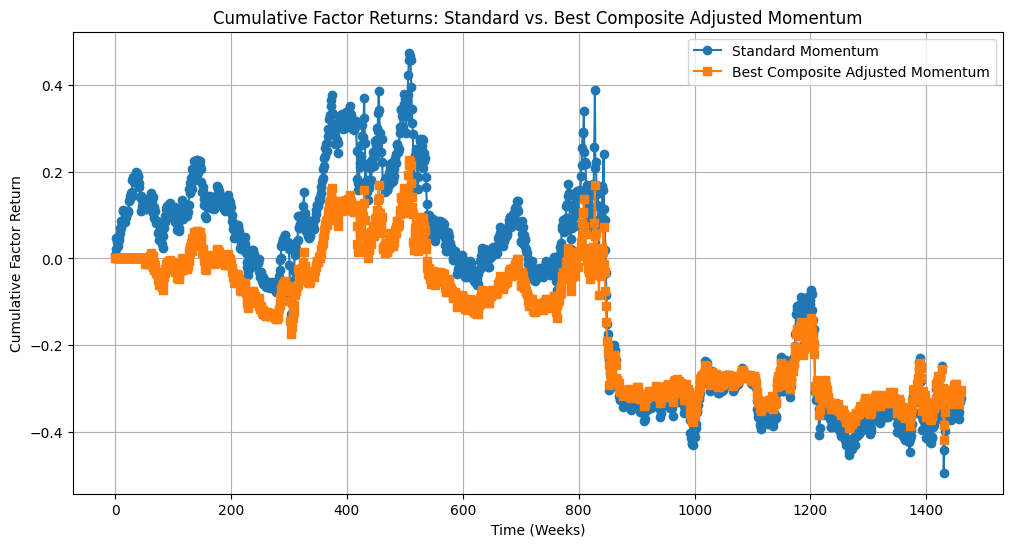

Standard Momentum Factor Returns:
Annualised Mean: -0.0114, Annualised Std: 0.1636
Sharpe Ratio: -0.06996386853084573

Best Composite Adjusted Momentum Factor Returns:
Annualised Mean: -0.0112, Annualised Std: 0.1103
Sharpe Ratio: -0.1014451831990984


In [7]:
# Now iterating over alpha and beta to determine the best composite signal

# Define a grid for alpha and beta
alphas = np.linspace(0.5, 1.5, 5)  
betas = np.linspace(-1.5, 1.5, 7)   

best_sharpe = -np.inf
best_alpha = None
best_beta = None
best_gamma = None

# Loop over all combinations
T, N = momentum.shape  
for a in alphas:
    for b in betas:
        # Compute composite momentum for each week using the current alpha and beta
        composite_momentum_temp = np.full_like(momentum, np.nan)
        for t in range(T):
            # Only adjust if comomentum[t] is available
            if np.isnan(comomentum[t]):
                continue
            # Broadcast comomentum[t] to all stocks for week t.
            composite_momentum_temp[t, :] = a * momentum[t, :] + b * comomentum[t]
        
        # Run the Fama–MacBeth regression using the composite momentum factor
        gamma_temp, _ = famaMacBethOneFactor(returns, composite_momentum_temp, live)
        
        # Remove NaNs and compute the annualised Sharpe ratio of the weekly factor returns.
        valid_gamma = gamma_temp[~np.isnan(gamma_temp)]
        if len(valid_gamma) == 0:
            continue
        annual_mean = np.mean(valid_gamma) * 52
        annual_std = np.std(valid_gamma) * np.sqrt(52)
        sharpe_temp = annual_mean / annual_std if annual_std != 0 else 0
        
        # Save if we obtain a higher Sharpe ratio.
        if sharpe_temp > best_sharpe:
            best_sharpe = sharpe_temp
            best_alpha = a
            best_beta = b
            best_gamma = gamma_temp

print("Best parameters:")
print("Alpha:", best_alpha)
print("Beta:", best_beta)
print("Best Sharpe Ratio:", best_sharpe)

# Now, recompute the composite momentum factor using the best parameters
composite_momentum_best = np.full_like(momentum, np.nan)
for t in range(T):
    if np.isnan(comomentum[t]):
        continue
    composite_momentum_best[t, :] = best_alpha * momentum[t, :] + best_beta * comomentum[t]

# Run Fama–MacBeth regression using the best composite momentum factor
gamma_composite_best, resid_composite_best = famaMacBethOneFactor(returns, composite_momentum_best, live)

# Plot cumulative factor returns for standard momentum vs. the best composite momentum.
# (Assume gamma_standard has been computed earlier)
cum_gamma_std = np.nancumsum(gamma_standard[1:])         
cum_gamma_best = np.nancumsum(gamma_composite_best[1:])     

# now plot
plt.figure(figsize=(12,6))
plt.plot(cum_gamma_std, label='Standard Momentum', marker='o')
plt.plot(cum_gamma_best, label='Best Composite Adjusted Momentum', marker='s')
plt.title("Cumulative Factor Returns: Standard vs. Best Composite Adjusted Momentum")
plt.xlabel("Time (Weeks)")
plt.ylabel("Cumulative Factor Return")
plt.legend()
plt.grid(True)
plt.show()

# Compute descriptive statistics for both factor return series.
valid_std = gamma_standard[~np.isnan(gamma_standard)]
valid_best = gamma_composite_best[~np.isnan(gamma_composite_best)]

annual_mean_std = np.mean(valid_std) * 52
annual_std_std = np.std(valid_std) * np.sqrt(52)
annual_mean_best = np.mean(valid_best) * 52
annual_std_best = np.std(valid_best) * np.sqrt(52)

print("Standard Momentum Factor Returns:")
print(f"Annualised Mean: {annual_mean_std:.4f}, Annualised Std: {annual_std_std:.4f}")
print("Sharpe Ratio:", annual_mean_std / annual_std_std if annual_std_std != 0 else np.nan)

print("\nBest Composite Adjusted Momentum Factor Returns:")
print(f"Annualised Mean: {annual_mean_best:.4f}, Annualised Std: {annual_std_best:.4f}")
print("Sharpe Ratio:", annual_mean_best / annual_std_best if annual_std_best != 0 else np.nan)


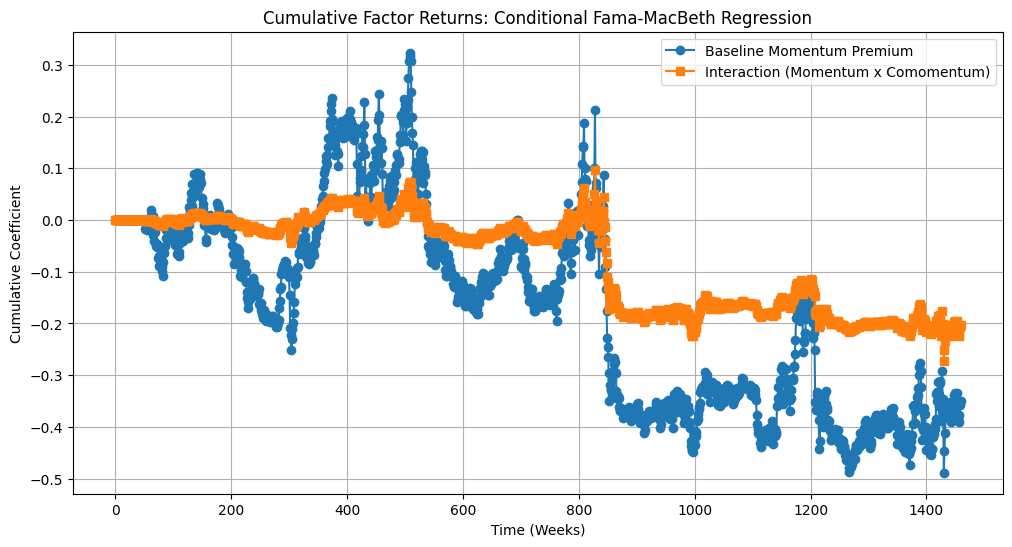

Conditional Fama-MacBeth Results:
Baseline Momentum Premium:
  Annualised Mean: -0.0130, Annualised Std: 0.1497, Sharpe Ratio: -0.0865
Interaction Effect (Momentum x Comomentum):
  Annualised Mean: -0.0075, Annualised Std: 0.0480, Sharpe Ratio: -0.1564


In [8]:
# Conditional Factor Modeling 

def famaMacBethConditional(returns, momentum, comomentum, live):
    
    T, N = returns.shape
    gamma = np.full((T, 2), np.nan)
    resid = np.full((T, N), np.nan)
    
    for t in range(1, T):
        # Dependent variable is one-week ahead returns at time t (for all stocks)
        Y = returns[t, :]
        # Explanatory variable is lagged momentum exposure at time t-1
        m_t = momentum[t-1, :]
        # Conditioning variable is comomentum at time t-1
        c_t = comomentum[t-1]
        
        # Create the interaction term
        interaction = m_t * c_t
        
        # Create a boolean mask: include stocks that are live at time t and with valid data
        valid = (live[t, :] == 1) & (~np.isnan(Y)) & (~np.isnan(m_t)) & (~np.isnan(interaction))
        if np.sum(valid) < 2:
            continue
        
        # Build design matrix: columns are [Intercept, momentum, interaction]
        X_valid = np.column_stack((np.ones(np.sum(valid)), m_t[valid], interaction[valid]))
        Y_valid = Y[valid]
        
        # Run the OLS regression for week t
        coefs, _, _, _ = np.linalg.lstsq(X_valid, Y_valid, rcond=None)
        # Save the coefficients for the momentum factor (γ₁) and the interaction (γ₂)
        gamma[t, 0] = coefs[1]
        gamma[t, 1] = coefs[2]
        
        # Compute residuals for valid observations
        pred = X_valid.dot(coefs)
        resid[t, valid] = Y_valid - pred
    
    return gamma, resid



gamma_cond, resid_cond = famaMacBethConditional(returns, momentum, comomentum, live)


cum_gamma_mom = np.nancumsum(gamma_cond[1:, 0])        
cum_gamma_int = np.nancumsum(gamma_cond[1:, 1])          

plt.figure(figsize=(12,6))
plt.plot(cum_gamma_mom, label='Baseline Momentum Premium', marker='o')
plt.plot(cum_gamma_int, label='Interaction (Momentum x Comomentum)', marker='s')
plt.title("Cumulative Factor Returns: Conditional Fama-MacBeth Regression")
plt.xlabel("Time (Weeks)")
plt.ylabel("Cumulative Coefficient")
plt.legend()
plt.grid(True)
plt.show()


valid_mom = gamma_cond[~np.isnan(gamma_cond[:,0]), 0]
valid_int = gamma_cond[~np.isnan(gamma_cond[:,1]), 1]

annual_mean_mom = np.mean(valid_mom) * 52
annual_std_mom = np.std(valid_mom) * np.sqrt(52)
annual_mean_int = np.mean(valid_int) * 52
annual_std_int = np.std(valid_int) * np.sqrt(52)

print("Conditional Fama-MacBeth Results:")
print("Baseline Momentum Premium:")
print(f"  Annualised Mean: {annual_mean_mom:.4f}, Annualised Std: {annual_std_mom:.4f}, Sharpe Ratio: {annual_mean_mom/annual_std_mom if annual_std_mom!=0 else np.nan:.4f}")
print("Interaction Effect (Momentum x Comomentum):")
print(f"  Annualised Mean: {annual_mean_int:.4f}, Annualised Std: {annual_std_int:.4f}, Sharpe Ratio: {annual_mean_int/annual_std_int if annual_std_int!=0 else np.nan:.4f}")


## Now we look at the cumulative returns of these strategies
- Threshold adjusted
- Best composite adjusted
- Conditionnal Fama-Macbeth adjusted
- Equally weighted PF as benchmark
### We compute the weights for each portfolio and compute their returns

In [9]:
comomentum = np.nan_to_num(comomentum, nan=0)
comomentum.size


def compute_momentum_weights(momentum_week, live_week, top_quantile=0.3):
    # Identify live stocks
    valid_idx = np.where(live_week == 1)[0]
    weights = np.zeros_like(momentum_week, dtype=float)
    if len(valid_idx) == 0:
        return weights  # no live stocks, so no investment
    
    # Extract momentum scores for live stocks
    mom_valid = momentum_week[valid_idx]
    
    # Determine threshold for top quantile
    threshold = np.quantile(mom_valid, 1 - top_quantile)
    
    # Stocks above threshold are selected
    selected = valid_idx[mom_valid >= threshold]
    if len(selected) > 0:
        weights[selected] = 1.0 / len(selected)
    
    return weights

def compute_equally_weighted_weights(live_week):

    valid_idx = np.where(live_week == 1)[0]
    weights = np.zeros_like(live_week, dtype=float)
    if len(valid_idx) > 0:
        weights[valid_idx] = 1.0 / len(valid_idx)
    return weights

T, N = returns.shape

# We'll define a comomentum threshold
# If comomentum[t] < threshold => we invest in the momentum portfolio
# else => we invest 0 in momentum (or skip)
comomentum_threshold = 0.5  

# Arrays to store weekly returns for our momentum strategy (with comomentum filter) and for the benchmark
strategy_return = np.full(T, np.nan)
benchmark_return = np.full(T, np.nan)

for t in range(T):
    # Identify which stocks are live at week t
    live_week = live[t, :]
    # Grab the returns for week t
    r_week = returns[t, :]
    
    # Compute the equally weighted portfolio of all live stocks as a benchmark
    w_eq = compute_equally_weighted_weights(live_week)
    benchmark_return[t] = np.nansum(w_eq * r_week)
    
    # Check comomentum at week t
    if not np.isnan(comomentum[t]) and comomentum[t] < comomentum_threshold:
        # If comomentum is "low," we invest in top momentum stocks
        w_mom = compute_momentum_weights(momentum[t, :], live_week, top_quantile=0.05)

        strategy_return[t] = np.nansum(w_mom * r_week)
    else:
        # If comomentum is high or NaN, we do not invest (or set return to 0)
        strategy_return[t] = 0.0

# Drop NaNs (if any) from the time series
valid_strat = strategy_return[~np.isnan(strategy_return)]
valid_bench = benchmark_return[~np.isnan(benchmark_return)]

# Compute cumulative returns by compounding
cum_strat = np.cumprod(1 + valid_strat) - 1
cum_bench = np.cumprod(1 + valid_bench) - 1


# Compute descriptive (annualized) statistics.
def annual_stats(weekly_returns):
    mean_weekly = np.mean(weekly_returns)
    std_weekly = np.std(weekly_returns)
    annual_mean = mean_weekly * 52
    annual_std = std_weekly * np.sqrt(52)
    sharpe = annual_mean / annual_std if annual_std != 0 else np.nan
    return annual_mean, annual_std, sharpe

valid_strat = valid_strat[~np.isnan(valid_strat)]
valid_bench = valid_bench[~np.isnan(valid_bench)]

ann_mean_strat, ann_std_strat, sharpe_strat = annual_stats(valid_strat)
ann_mean_bench, ann_std_bench, sharpe_bench = annual_stats(valid_bench)

print("Momentum (Comomentum-Filtered) Strategy:")
print(f"  Annualised Return: {ann_mean_strat:.4f}, Annualised Std: {ann_std_strat:.4f}, Sharpe: {sharpe_strat:.4f}")



Momentum (Comomentum-Filtered) Strategy:
  Annualised Return: 0.2108, Annualised Std: 0.2822, Sharpe: 0.7469


In [10]:

# Grid Search for Best Composite Signal 
alphas = np.linspace(0.5, 1.5, 5)   
betas = np.linspace(-1.5, 1.5, 7)   

best_sharpe = -np.inf
best_alpha = None
best_beta = None
best_gamma = None


T, N = momentum.shape 

for a in alphas:
    for b in betas:
        # Compute composite momentum for each week using current alpha and beta
        composite_momentum_temp = np.full_like(momentum, np.nan)
        for t in range(T):
            if np.isnan(comomentum[t]):
                continue
            # Compute composite momentum: only long positions (by using our compute_momentum_weights later)
            composite_momentum_temp[t, :] = a * momentum[t, :] + b * comomentum[t]
        
        # Run Fama–MacBeth regression using the composite momentum factor
        gamma_temp, _ = famaMacBethOneFactor(returns, composite_momentum_temp, live)
        
        # Remove NaNs and compute the annualised Sharpe ratio of the weekly factor returns
        valid_gamma = gamma_temp[~np.isnan(gamma_temp)]
        if len(valid_gamma) == 0:
            continue
        annual_mean = np.mean(valid_gamma) * 52
        annual_std = np.std(valid_gamma) * np.sqrt(52)
        sharpe_temp = annual_mean / annual_std if annual_std != 0 else 0
        
        if sharpe_temp > best_sharpe:
            best_sharpe = sharpe_temp
            best_alpha = a
            best_beta = b
            best_gamma = gamma_temp

print("Best parameters from grid search:")
print("Alpha:", best_alpha)
print("Beta:", best_beta)
print("Best Sharpe Ratio:", best_sharpe)

# Recompute Best Composite Adjusted Momentum Factor 
composite_momentum_best = np.full_like(momentum, np.nan)
for t in range(T):
    if np.isnan(comomentum[t]):
        continue
    composite_momentum_best[t, :] = best_alpha * momentum[t, :] + best_beta * comomentum[t]

# Define a Long-Only Weighting Function 
def compute_long_only_weights(signal, live_week, quantile=0.1):

    valid_idx = np.where(live_week == 1)[0]
    weights = np.zeros_like(signal, dtype=float)
    if len(valid_idx) == 0:
        return weights
    valid_signal = signal[valid_idx]
    threshold = np.quantile(valid_signal, 1 - quantile)
    selected = valid_idx[valid_signal >= threshold]
    if len(selected) > 0:
        weights[selected] = 1.0 / len(selected)
    return weights

# Construct the Best Composite Adjusted Momentum Strategy
strategy_return_composite = np.full(T, np.nan)

for t in range(T):
    live_week = live[t, :]
    r_week = returns[t, :]
    # Use composite_momentum_best as the signal
    # Compute long-only weights (only invest in stocks with high composite signal)
    w_comp = compute_long_only_weights(composite_momentum_best[t, :], live_week, quantile=0.1)
    strategy_return_composite[t] = np.nansum(w_comp * r_week)

# Compute Benchmark (Equally Weighted) Portfolio Returns
strategy_return_equal = np.full(T, np.nan)
for t in range(T):
    live_week = live[t, :]
    r_week = returns[t, :]
    w_equal = compute_equally_weighted_weights(live_week)
    strategy_return_equal[t] = np.nansum(w_equal * r_week)

# Compute descriptive (annualized) statistics.
valid_comp = strategy_return_composite[~np.isnan(strategy_return_composite)]
valid_equal = strategy_return_equal[~np.isnan(strategy_return_equal)]

cum_ret_comp = np.cumprod(1 + valid_comp) - 1
cum_ret_equal = np.cumprod(1 + valid_equal) - 1

ann_mean_comp, ann_std_comp, sharpe_comp = annual_stats(valid_comp)
ann_mean_equal, ann_std_equal, sharpe_equal = annual_stats(valid_equal)

print("Best Composite Adjusted Momentum Strategy:")
print(f"Annualised Return: {ann_mean_comp:.4f}, Annualised Std: {ann_std_comp:.4f}, Sharpe Ratio: {sharpe_comp:.4f}")

Best parameters from grid search:
Alpha: 1.5
Beta: 0.0
Best Sharpe Ratio: -0.06996386853084562
Best Composite Adjusted Momentum Strategy:
Annualised Return: 0.2399, Annualised Std: 0.2595, Sharpe Ratio: 0.9245


In [11]:
# New cell: Conditional Trading Strategy Based on Conditional Fama–MacBeth Regression

def compute_long_only_weights(signal, live_week, quantile=0.1):
    """
    Computes long-only portfolio weights based on a given signal for live stocks.
    Stocks in the top quantile (default 10%) are selected; others receive zero weight.
    
    Parameters:
      signal: 1D array (N,) of signal values.
      live_week: 1D array (N,) of live indicators.
      quantile: fraction for selecting top stocks (default 0.1).
      
    Returns:
      weights: 1D array (N,) of portfolio weights that sum to 1 among the selected stocks.
    """
    valid_idx = np.where(live_week == 1)[0]
    weights = np.zeros_like(signal, dtype=float)
    if len(valid_idx) == 0:
        return weights
    valid_signal = signal[valid_idx]
    threshold = np.quantile(valid_signal, 1 - quantile)
    selected = valid_idx[valid_signal >= threshold]
    if len(selected) > 0:
        weights[selected] = 1.0 / len(selected)
    return weights

# We'll simulate a strategy based on the conditional model.
# For each week t from 1 to T-2, we use gamma_cond[t, :] to compute a predicted return signal 
# for each stock at week t, and then we form a long-only portfolio for week t+1.
# (We start at t=1 because gamma_cond[0] is not used; we use t+1 returns so we go up to T-2.)

T, N = returns.shape
strategy_return_conditional = np.full(T, np.nan)

# Loop from t=1 to T-2, so that t+1 is within bounds.
for t in range(1, T-1):
    # Use the conditional regression coefficients from week t.
    if np.isnan(gamma_cond[t, 0]) or np.isnan(gamma_cond[t, 1]) or np.isnan(comomentum[t]):
        continue
    # Compute predicted return signal for each stock at week t.
    # Equation: predicted_signal = γ₁,t * momentum[t, :] + γ₂,t * (momentum[t, :] * comomentum[t])
    predicted_signal = gamma_cond[t, 0] * momentum[t, :] + gamma_cond[t, 1] * (momentum[t, :] * comomentum[t])
    
    # Trading decision is based on predicted signal at week t, but we invest in week t+1.
    # Use live status at week t+1.
    live_week_next = live[t+1, :]
    
    # Compute long-only weights based on the predicted signal for live stocks.
    weights = compute_long_only_weights(predicted_signal, live_week_next, quantile=0.1)
    
    # Compute portfolio return for week t+1 (using returns at t+1).
    strategy_return_conditional[t+1] = np.nansum(weights * returns[t+1, :])

# For any weeks not set, set return to 0.
strategy_return_conditional[np.isnan(strategy_return_conditional)] = 0.0

# Compute cumulative returns by compounding the weekly strategy returns.
cum_ret_conditional = np.cumprod(1 + strategy_return_conditional) - 1

# For comparison, compute cumulative returns for an equally weighted benchmark (using only live stocks).
strategy_return_equal = np.full(T, np.nan)
for t in range(T):
    live_week = live[t, :]
    r_week = returns[t, :]
    w_equal = compute_equally_weighted_weights(live_week)
    strategy_return_equal[t] = np.nansum(w_equal * r_week)
strategy_return_equal[np.isnan(strategy_return_equal)] = 0.0
cum_ret_equal = np.cumprod(1 + strategy_return_equal) - 1


# Compute descriptive (annualized) statistics.

valid_cond_returns = strategy_return_conditional[~np.isnan(strategy_return_conditional)]
valid_equal_returns = strategy_return_equal[~np.isnan(strategy_return_equal)]

ann_mean_cond, ann_std_cond, sharpe_cond = annual_stats(valid_cond_returns)
ann_mean_equal, ann_std_equal, sharpe_equal = annual_stats(valid_equal_returns)

print("Conditional Trading Strategy:")
print(f"  Annualised Return: {ann_mean_cond:.4f}, Annualised Std: {ann_std_cond:.4f}, Sharpe Ratio: {sharpe_cond:.4f}")


Conditional Trading Strategy:
  Annualised Return: 0.2572, Annualised Std: 0.2899, Sharpe Ratio: 0.8871


# Final plot for comparison

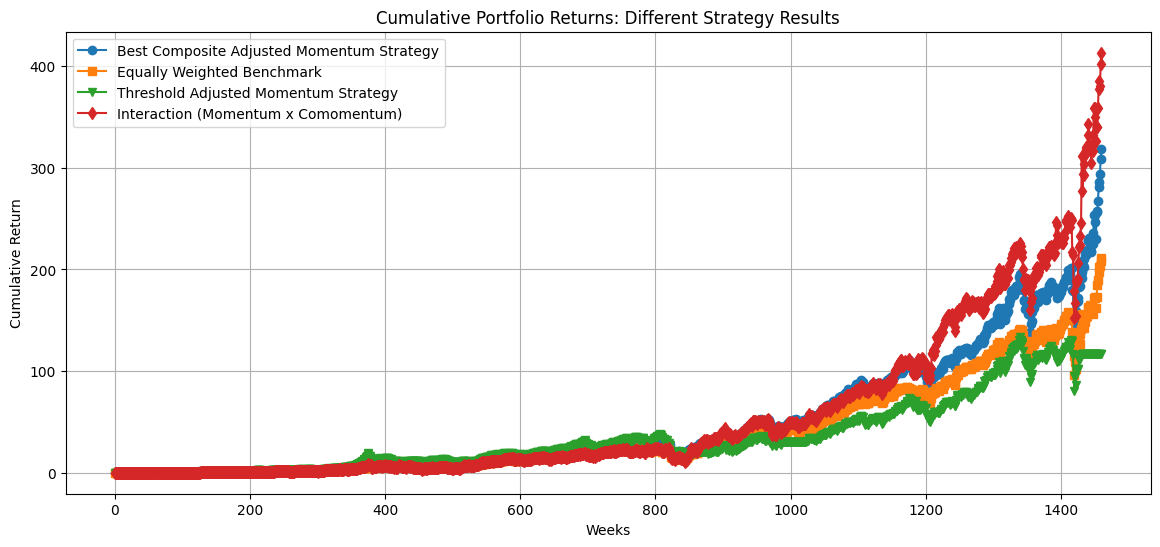

Conditional Trading Strategy:
  Annualised Return: 0.2572, Annualised Std: 0.2899, Sharpe Ratio: 0.8871
Best Composite Adjusted Momentum Strategy:
  Annualised Return: 0.2399, Annualised Std: 0.2595, Sharpe Ratio: 0.9245
Momentum (Comomentum-Filtered) Strategy:
  Annualised Return: 0.2108, Annualised Std: 0.2822, Sharpe: 0.7469

Equally Weighted Benchmark:
  Annualised Return: 0.2116, Annualised Std: 0.2027, Sharpe Ratio: 1.0439


In [12]:
plt.figure(figsize=(14,6))
plt.plot(cum_ret_comp, label='Best Composite Adjusted Momentum Strategy', marker='o')
plt.plot(cum_ret_equal, label='Equally Weighted Benchmark', marker='s')
plt.plot(cum_strat, label='Threshold Adjusted Momentum Strategy', marker='v')
plt.plot(cum_ret_conditional, label='Interaction (Momentum x Comomentum)', marker='d')
plt.title("Cumulative Portfolio Returns: Different Strategy Results")
plt.xlabel("Weeks")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()
print("Conditional Trading Strategy:")
print(f"  Annualised Return: {ann_mean_cond:.4f}, Annualised Std: {ann_std_cond:.4f}, Sharpe Ratio: {sharpe_cond:.4f}")
print("Best Composite Adjusted Momentum Strategy:")
print(f"  Annualised Return: {ann_mean_comp:.4f}, Annualised Std: {ann_std_comp:.4f}, Sharpe Ratio: {sharpe_comp:.4f}")
print("Momentum (Comomentum-Filtered) Strategy:")
print(f"  Annualised Return: {ann_mean_strat:.4f}, Annualised Std: {ann_std_strat:.4f}, Sharpe: {sharpe_strat:.4f}")
print("\nEqually Weighted Benchmark:")
print(f"  Annualised Return: {ann_mean_equal:.4f}, Annualised Std: {ann_std_equal:.4f}, Sharpe Ratio: {sharpe_equal:.4f}")